#**Task 1: Image Denoising and Video Processing**

###**Part 1: Image Denoising**

In [1]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.7 MB/s eta 0:00:00


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


<ipython-input-6-0323952a9e45>:60: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = metrics.peak_signal_noise_ratio(original_gray, denoised_gray)


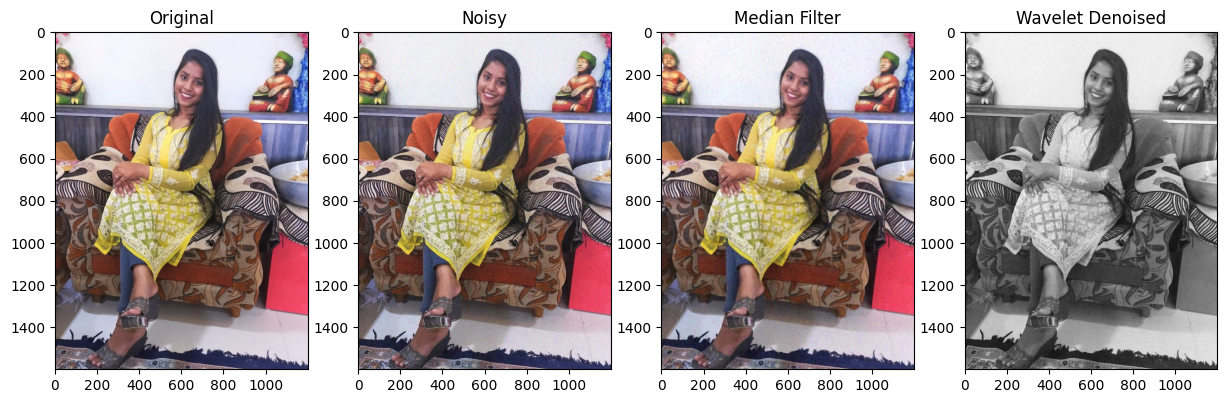


Image 1 Metrics:
Median Filter: {'MSE': np.float64(172.91968229166667), 'PSNR': np.float64(25.75235931942352), 'SSIM': np.float64(0.7241096678331541)}
Wavelet Denoising: {'MSE': np.float64(23108.785521359816), 'PSNR': np.float64(4.4930323906822025), 'SSIM': np.float64(0.0005192421875640985)}
Noise2Void: {'MSE': np.float64(19314.347778125), 'PSNR': np.float64(5.272003137323389), 'SSIM': np.float64(0.025573982499585753)}


[{'image': 1,
  'median': {'MSE': np.float64(172.91968229166667),
   'PSNR': np.float64(25.75235931942352),
   'SSIM': np.float64(0.7241096678331541)},
  'wavelet': {'MSE': np.float64(23108.785521359816),
   'PSNR': np.float64(4.4930323906822025),
   'SSIM': np.float64(0.0005192421875640985)},
  'noise2void': {'MSE': np.float64(19314.347778125),
   'PSNR': np.float64(5.272003137323389),
   'SSIM': np.float64(0.025573982499585753)}}]

In [6]:
import cv2
import numpy as np
from skimage import filters, metrics, restoration
from skimage.util import random_noise
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D
from keras.models import Model
import os

# Load sample images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

# Add noise to images for denoising demonstration
def add_noise(image, noise_type='gaussian'):
    if noise_type == 'gaussian':
        noisy = random_noise(image, mode='gaussian', var=0.01)
    elif noise_type == 'salt_pepper':
        noisy = random_noise(image, mode='s&p', amount=0.05)
    elif noise_type == 'poisson':
        noisy = random_noise(image, mode='poisson')
    return np.array(255 * noisy, dtype=np.uint8)

# Denoising techniques
def median_filter(image):
    return cv2.medianBlur(image, 5)

def wavelet_denoise(image):
    # Convert to grayscale for simplicity
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return restoration.denoise_wavelet(gray, rescale_sigma=True)

def noise2void_denoise(image):
    # Simplified implementation (actual Noise2Void requires trained model)
    # Here we'll use a simple CNN as a placeholder
    inputs = Input(shape=(None, None, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    model = Model(inputs, x)

    # In a real scenario, this would be a pre-trained Noise2Void model
    processed = model.predict(np.expand_dims(image, axis=0))/255.0
    return np.clip(processed[0] * 255, 0, 255).astype(np.uint8)

# Evaluate denoising performance
def evaluate_denoising(original, denoised):
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    if denoised.ndim == 3:
        denoised_gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    else:
        denoised_gray = denoised

    mse = metrics.mean_squared_error(original_gray, denoised_gray)
    psnr = metrics.peak_signal_noise_ratio(original_gray, denoised_gray)
    ssim = metrics.structural_similarity(original_gray, denoised_gray, data_range=denoised_gray.max() - denoised_gray.min())

    return {'MSE': mse, 'PSNR': psnr, 'SSIM': ssim}

# Main denoising comparison
def compare_denoising(image_path):  # Change the parameter name to image_path
    # Load the single image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    results = []
    noisy = add_noise(img)

    # Apply denoising techniques
    median = median_filter(noisy)
    wavelet = wavelet_denoise(noisy)
    n2v = noise2void_denoise(noisy)

    # Evaluate
    median_metrics = evaluate_denoising(img, median)
    wavelet_metrics = evaluate_denoising(img, wavelet)
    n2v_metrics = evaluate_denoising(img, n2v)

    results.append({
        'image': 1,  # Since we're processing a single image
        'median': median_metrics,
        'wavelet': wavelet_metrics,
        'noise2void': n2v_metrics
    })
    # Moved plotting commands outside the loop
    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB))
    plt.title('Noisy')

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
    plt.title('Median Filter')

    plt.subplot(1, 4, 4)
    plt.imshow(wavelet, cmap='gray')
    plt.title('Wavelet Denoised')

    plt.show()

    # Print metrics
    for result in results:
        print(f"\nImage {result['image']} Metrics:")
        print("Median Filter:", result['median'])
        print("Wavelet Denoising:", result['wavelet'])
        print("Noise2Void:", result['noise2void'])

    return results

# Example usage
compare_denoising('/content/Prajakta.jpg')

###**Part 2: Extract Images from Video**

In [7]:
def extract_frames(video_path, output_folder, frame_interval=1):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame at specified interval
        if frame_count % frame_interval == 0:
            frame_name = f"frame_{saved_count:04d}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_count} frames from {frame_count} total frames")

# Example usage
extract_frames('/content/13002857_2160_4096_30fps.mp4', 'output_frames')

Extracted 500 frames from 500 total frames


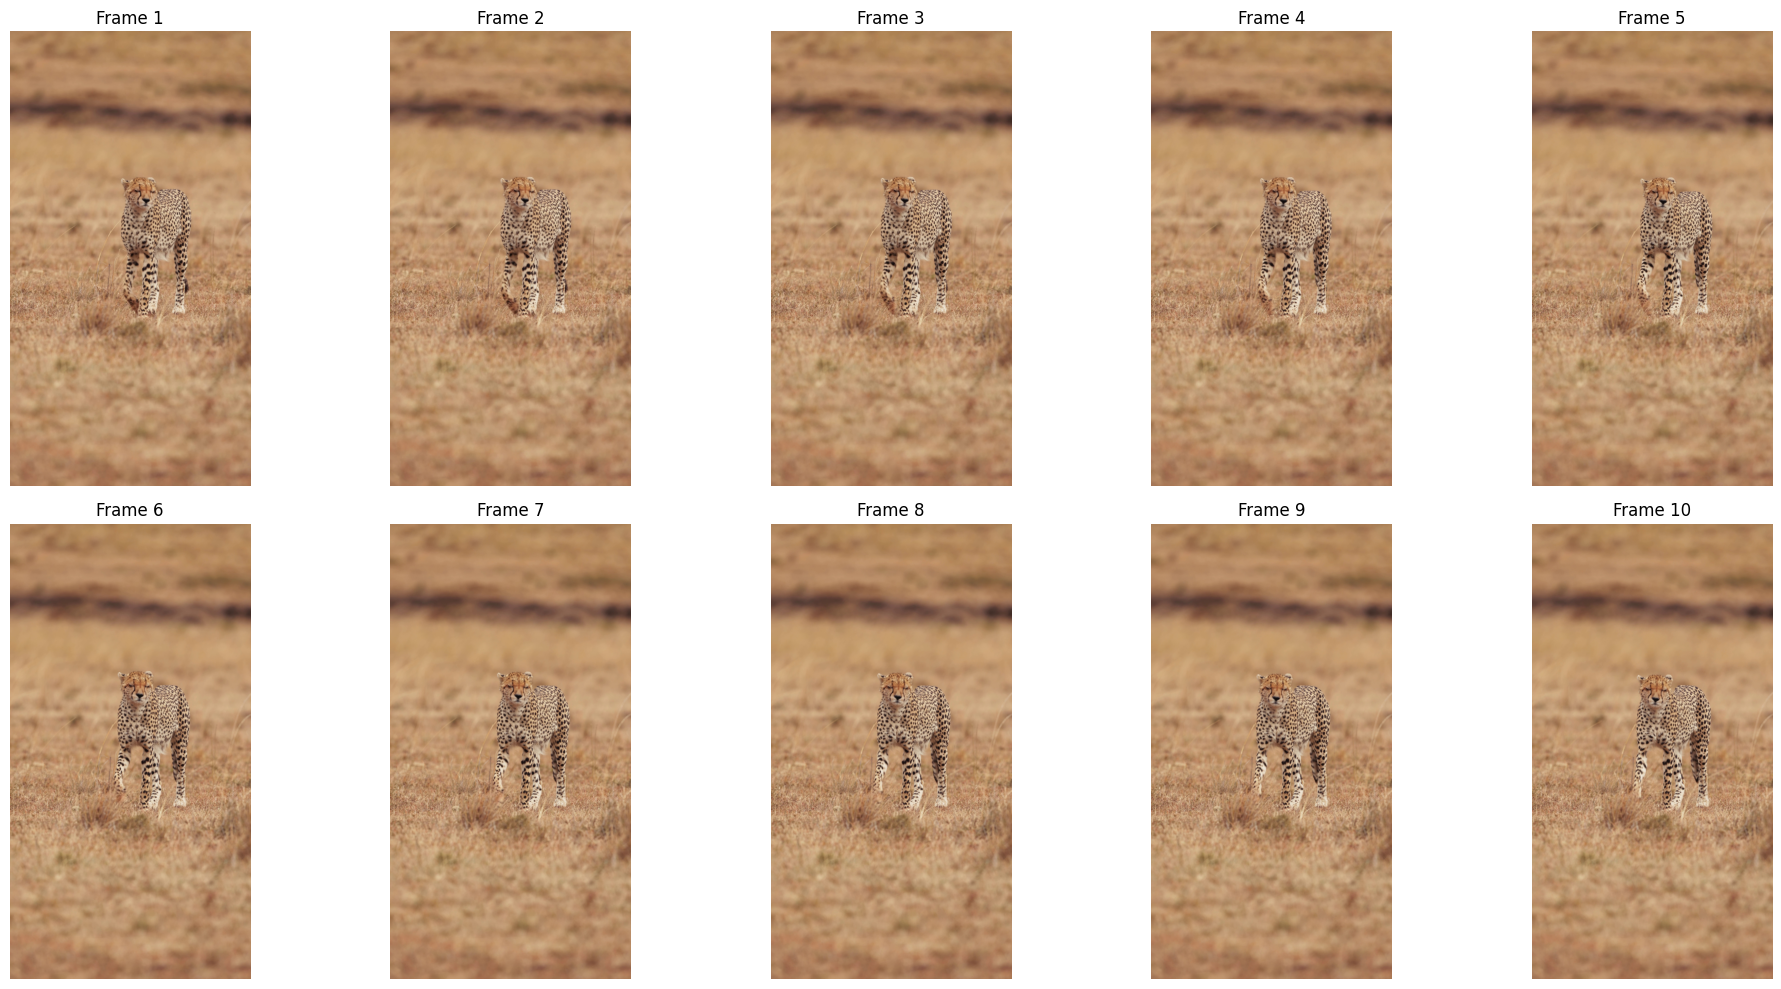

In [8]:
import cv2
import os
import matplotlib.pyplot as plt

def show_first_n_frames(frames_folder, n=10):
    # Get list of frame files sorted by name
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')])

    # Create figure
    plt.figure(figsize=(20, 10))

    # Display first n frames
    for i, frame_file in enumerate(frame_files[:n]):
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(frame)
        plt.title(f"Frame {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_first_n_frames('output_frames', 10)

###**Part 3: Process Video Frames and Recreate Video**

In [9]:
def process_video(input_path, output_path, operation='threshold'):
    cap = cv2.VideoCapture(input_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply selected operation
        if operation == 'threshold':
            processed = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 11, 2)
        elif operation == 'gaussian':
            processed = cv2.GaussianBlur(gray, (5, 5), 0)
        elif operation == 'canny':
            processed = cv2.Canny(gray, 100, 200)
        elif operation == 'bitwise_not':
            processed = cv2.bitwise_not(gray)

        # Write processed frame
        out.write(processed)

    cap.release()
    out.release()
    print(f"Processed video saved to {output_path}")

# Example usage
process_video('/content/13002857_2160_4096_30fps.mp4', 'threshold_output.mp4', 'threshold')
process_video('/content/13002857_2160_4096_30fps.mp4', 'gaussian_output.mp4', 'gaussian')
process_video('/content/13002857_2160_4096_30fps.mp4', 'canny_output.mp4', 'canny')
process_video('/content/13002857_2160_4096_30fps.mp4', 'bitwise_output.mp4', 'bitwise_not')

Processed video saved to threshold_output.mp4
Processed video saved to gaussian_output.mp4
Processed video saved to canny_output.mp4
Processed video saved to bitwise_output.mp4


###**Part 4: Create Collage from Video Frames**

In [ ]:
def create_collage(video_path, output_path, grid_size=(3, 3)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_select = grid_size[0] * grid_size[1]
    step = max(1, total_frames // frames_to_select)

    selected_frames = []
    for i in range(frames_to_select):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if ret:
            selected_frames.append(frame)

    cap.release()

    if len(selected_frames) < frames_to_select:
        print(f"Warning: Only got {len(selected_frames)} frames, expected {frames_to_select}")
        grid_size = (int(np.sqrt(len(selected_frames))), int(np.sqrt(len(selected_frames))))

    # Resize frames to same size
    h, w = selected_frames[0].shape[:2]
    resized_frames = [cv2.resize(f, (w//2, h//2)) for f in selected_frames]

    # Create collage
    rows = []
    for i in range(grid_size[0]):
        row = np.hstack(resized_frames[i*grid_size[1]:(i+1)*grid_size[1]])
        rows.append(row)

    collage = np.vstack(rows)
    cv2.imwrite(output_path, collage)
    print(f"Collage saved to {output_path}")

# Example usage
create_collage('/content/13002857_2160_4096_30fps.mp4', 'collage.jpg')

Collage saved to collage.jpg


Loading training data...
Training data shape: (11, 16, 112, 112, 3)
Loading validation data...
Validation data shape: (50, 16, 112, 112, 3)
Loading test data...
Test data shape: (50, 16, 112, 112, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 128)        │        94,144 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,877 (562.02 KB)

 Trainable params: 143,429 (560.27 KB)

 Non-trainable params: 448 (1.75 KB)

Training model...
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.1212 - loss: 1.7195 - val_accuracy: 0.2000 - val_loss: 1.6270
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 419ms/step - accuracy: 0.7348 - loss: 0.9876 - val_accuracy: 0.2200 - val_loss: 1.6233
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.6326 - loss: 1.0572 - val_accuracy: 0.2400 - val_loss: 1.6052
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.7765 - loss: 1.1097 - val_accuracy: 0.2000 - val_loss: 1.6415
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.7955 - loss: 0.6916 - val_accuracy: 0.2000 - val_loss: 1.6956
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - accuracy: 0.8371 - loss: 0.7227 - val_accuracy: 0.2000 - val_loss: 1.7631
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8371 - loss: 0.7125 - val_accuracy: 0.1800 - val_loss: 1.8420
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8182 - loss: 0.6272 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


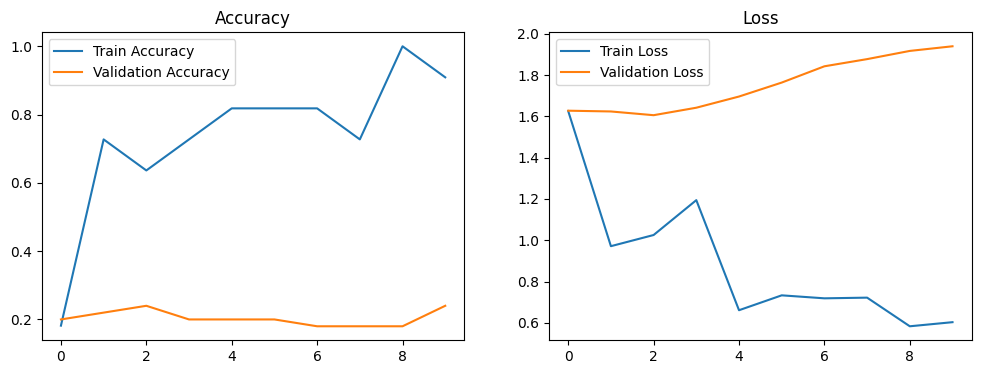

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def extract_video_frames(video_path, frame_interval, target_size, seq_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame = cv2.resize(frame, target_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame / 255.0
            frames.append(frame)
            if len(frames) >= seq_length:
                break

        frame_count += 1

    cap.release()

    # Pad with zeros if we didn't get enough frames
    while len(frames) < seq_length:
        frames.append(np.zeros((target_size[0], target_size[1], 3)))

    return np.array(frames[:seq_length])

def load_data_from_csv(csv_path, dataset_root, selected_classes, max_videos_per_class=None,
                      frame_interval=5, target_size=(112, 112), seq_length=16):
    df = pd.read_csv(csv_path)
    df = df[df['label'].isin(selected_classes)]

    if max_videos_per_class:
        df = df.groupby('label').head(max_videos_per_class)

    le = LabelEncoder()
    le.fit(selected_classes)

    X = []
    y = []

    for _, row in df.iterrows():
        video_path = os.path.join(dataset_root, row['clip_path'].lstrip('/'))
        if not os.path.exists(video_path):
            print(f"Warning: Video file not found: {video_path}")
            continue

        frames = extract_video_frames(video_path, frame_interval, target_size, seq_length)
        X.append(frames)
        y.append(row['label'])

    if not X:  # If no videos were loaded
        raise ValueError(f"No valid videos found in {csv_path} for selected classes")

    X = np.array(X)
    y = le.transform(y)
    y = tf.keras.utils.to_categorical(y, num_classes=len(selected_classes))

    return X, y, le.classes_

def build_cnn_lstm_model(input_shape, num_classes):
    # CNN part
    cnn_input = layers.Input(shape=(input_shape[1], input_shape[2], input_shape[3]))

    x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    cnn_model = models.Model(cnn_input, x)

    # LSTM part
    model_input = layers.Input(shape=input_shape)
    x = layers.TimeDistributed(cnn_model)(model_input)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(model_input, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate():
    # Parameters
    SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
    MAX_VIDEOS_PER_CLASS = 20  # Limit to prevent memory issues
    FRAME_INTERVAL = 5
    SEQ_LENGTH = 16
    TARGET_SIZE = (112, 112)
    EPOCHS = 10
    BATCH_SIZE = 8
    DATA_ROOT = '/content/drive/MyDrive/UCF101'  # Update this path

    # Load datasets
    print("Loading training data...")
    try:
        X_train, y_train, class_names = load_data_from_csv(
            os.path.join(DATA_ROOT, 'train.csv'),
            DATA_ROOT,  # Use DATA_ROOT directly
            SELECTED_CLASSES,
            MAX_VIDEOS_PER_CLASS,
            FRAME_INTERVAL,
            TARGET_SIZE,
            SEQ_LENGTH
        )
        print(f"Training data shape: {X_train.shape}")
    except Exception as e:
        print(f"Error loading training data: {e}")
        return None, None

    print("Loading validation data...")
    try:
        X_val, y_val, _ = load_data_from_csv(
            os.path.join(DATA_ROOT, 'val.csv'),
            DATA_ROOT,  # Use DATA_ROOT directly
            SELECTED_CLASSES,
            MAX_VIDEOS_PER_CLASS//2,  # Fewer validation samples
            FRAME_INTERVAL,
            TARGET_SIZE,
            SEQ_LENGTH
        )
        print(f"Validation data shape: {X_val.shape}")
    except Exception as e:
        print(f"Error loading validation data: {e}")
        return None, None

    print("Loading test data...")
    try:
        X_test, y_test, _ = load_data_from_csv(
            os.path.join(DATA_ROOT, 'test.csv'),
            DATA_ROOT,  # Use DATA_ROOT directly
            SELECTED_CLASSES,
            MAX_VIDEOS_PER_CLASS//2,  # Fewer test samples
            FRAME_INTERVAL,
            TARGET_SIZE,
            SEQ_LENGTH
        )
        print(f"Test data shape: {X_test.shape}")
    except Exception as e:
        print(f"Error loading test data: {e}")
        return None, None

    # Build model
    input_shape = (SEQ_LENGTH, TARGET_SIZE[0], TARGET_SIZE[1], 3)
    model = build_cnn_lstm_model(input_shape, len(SELECTED_CLASSES))
    model.summary()

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Evaluate
    print("Evaluating on test set...")
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {test_acc:.4f}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_classes, y_pred_classes))

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

    return model, history

# Run the training
model, history = train_and_evaluate()